In [1]:
import pandas as pd
import numpy as np

np.random.seed(12345)

df = pd.DataFrame([np.random.normal(32000,200000,3650), 
                   np.random.normal(43000,100000,3650), 
                   np.random.normal(43500,140000,3650), 
                   np.random.normal(48000,70000,3650)], 
                  index=[1992,1993,1994,1995])

In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import colorsys
import math

In [3]:
class InteractiveGraph:
    
    def __init__(self, df, y_hl_init):
        self.y_1 = y_hl_init
        self.y_2 = y_hl_init
        self.df_hist = pd.DataFrame({
            'mean': df.mean(axis=1),
            'confidence': 1.645 * df.std(axis=1) / len(df.iloc[0]) ** 0.5
        })
        self.data_mean = self.df_hist['mean'].values
        self.data_confidence = self.df_hist['confidence'].values
        self.years = np.arange(0, len(self.df_hist))
        
        
    def avg_color(self, color, factor, mid_hsv=(0.0, 0.0, 1.0), center_avg=False):
        if center_avg:
            factor = np.abs(2 * factor - 1)
        colors = colorsys.hsv_to_rgb(*(
            color[0],
            color[1] * factor + mid_hsv[1] * (1.0 - factor),
            color[2] * factor + mid_hsv[2] * (1.0 - factor)
        ))
        return '#{:02x}{:02x}{:02x}'.format(*(int(255 * c) for c in colors))
    
    
    def make_colors(self, y_1, y_2=False):
        mean, conf = self.data_mean, self.data_confidence
        ranges = np.linspace(-0.0001, 1.0, 10) # fix to include p=0 on strict less than test
        bins = zip(ranges[:-1], ranges[1:])
        if not y_2:
            self.ax.set_title('Split probability view')
            self.y_1 = y_1
            probas = np.array([
                    0.5 * (1 + math.erf(1.645 * (y_1 - m)/(2**0.5 * c)))
                    for m, c in zip(mean, conf)])
            mid_hsv = (0.0, 0.0, 1.0)
            lo_hsv = (0.5, 0.8, 0.7)
            hi_hsv = (0.1, 1.0, 0.9)
            center_color_avg = True
        else:
            self.ax.set_title('Range probability view')
            y_1 = self.y_1
            self.y_2 = y_2
            if y_1 > y_2:
                y_1, y_2 = y_2, y_1
            mid_hsv = (0.0, 0.0, 1.0)
            hi_hsv = lo_hsv = (0.7, 0.8, 0.7)
            probas = np.array([
                    0.5 * (math.erf(1.645 * (y_2 - m)/(2**0.5 * c)) -
                           math.erf(1.645 * (y_1 - m)/(2**0.5 * c)))
                    for m, c in zip(mean, conf)])
            center_color_avg = False
        conditions = [(probas > lo) & (probas <= hi) for lo, hi in bins]
        color_options = np.linspace(0.0, 1.0, len(conditions))
        color_options = [(lo_hsv if i > 0.5 else hi_hsv, abs(i)) for i in color_options]
        color_options = [
            self.avg_color(c, factor, mid_hsv=mid_hsv, center_avg=center_color_avg)
            for c, factor in color_options]
        colors = np.select(conditions, color_options, default='r')
        return colors 
    
    
    def on_press(self, event):
        y_1 = event.ydata
        new_colors = self.make_colors(y_1)
        for i, bar in enumerate(self.bars.patches):
            bar.set_facecolor(new_colors[i])
        self.hline_1.set_ydata(y_1)
        self.bbox_1.set_text('{:.0f}'.format(y_1))
        self.bbox_1.set_y(y_1)
        self.hline_2.set_visible(False)
        self.bbox_2.set_visible(False)
        self.hl_rect.set_visible(False)

        
    def on_release(self, event):
        y_2 = event.ydata
        if y_2 != self.y_1:
            new_colors = self.make_colors(self.y_1, y_2)
            for i, bar in enumerate(self.bars.patches):
                bar.set_facecolor(new_colors[i])
            self.hline_2.set_ydata(y_2)
            self.hline_2.set_visible(True)
            self.bbox_2.set_text('{:.0f}'.format(y_2))
            self.bbox_2.set_y(y_2)
            self.bbox_2.set_visible(True)
            self.hl_rect.set_y(min(self.y_1, y_2))
            self.hl_rect.set_height(abs(self.y_1 - y_2))
            self.hl_rect.set_visible(True)
    
    
    def listen(self):
        self.fig.canvas.mpl_connect('button_press_event', self.on_press)
        self.fig.canvas.mpl_connect('button_release_event', self.on_release)
    
    
    def plot(self):
        self.fig = plt.figure()
        ax = self.fig.add_subplot(1, 1, 1)
        self.ax = ax
        self.bars = ax.bar(
            self.years, self.data_mean,
            color=self.make_colors(self.y_1), edgecolor='#777777',
            yerr=self.data_confidence, ecolor='#777777', capsize=10,
        )
        self.hline_1 = ax.axes.axhline(self.y_1, color='y')
        self.hline_2 = ax.axes.axhline(0, color='y')
        self.hline_2.set_visible(False)
        ax.set_title('Assignment 3')
        ax.axes.set_xlabel('Year')
        ax.axes.set_xticks(self.years)
        ax.axes.set_xticklabels(self.df_hist.index)
        ax.axes.set_ylabel('Some value of interest')
        ax.axes.set_ylim(
            -200,
            self.data_mean.max() + self.data_confidence.max() + 2000)
        ax.grid(axis='y', color='#333333', linestyle=':', alpha=0.3)
        ax.axes.set_yticklabels(['0'] + ['{:.0f}k'.format(y_tick/1000) for y_tick in ax.axes.get_yticks()[1:]])
        ax.tick_params(bottom=False, left=False)
        for s in ax.spines:
            ax.spines[s].set_visible(False)
        props = dict(boxstyle='round', facecolor='w', edgecolor='y', alpha=1)
        self.bbox_1 = ax.text(len(self.years)-0.51, self.y_1, self.y_1, bbox=props, verticalalignment='center')
        self.bbox_2 = ax.text(len(self.years)-0.51, 0, 0, bbox=props, verticalalignment='center')
        self.bbox_2.set_visible(False)
        self.hl_rect = patches.Rectangle(
            (-0.5,0),len(self.years),0,
            facecolor='y', alpha=0.15)
        self.hl_rect.set_visible(False)
        # Add the patch to the Axes
        ax.add_patch(self.hl_rect)
        plt.show()
        
        

# Instructions

- Click anywhere for a split probability view (blue-orange)
- Click, drag & release for a range probability view (purple)

<IPython.core.display.Javascript object>


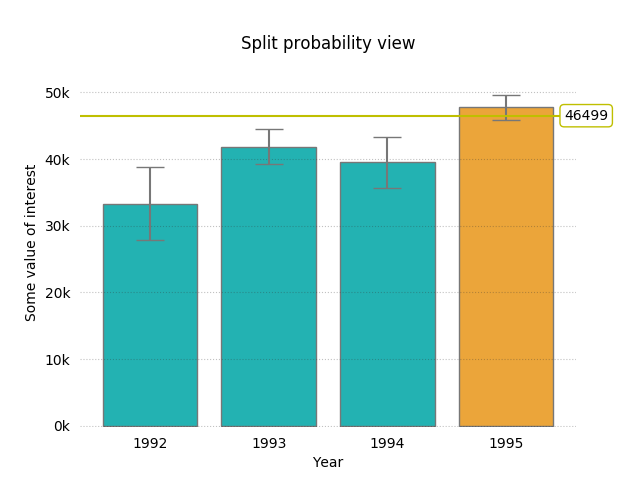

In [4]:
ig = InteractiveGraph(df, y_hl_init=40000)
ig.plot()
ig.listen()